In [12]:
import copy
import os
import argparse
import torch
import numpy as np
import random

%load_ext autoreload
%autoreload 2
from erasure.utils.config.local_ctx import Local
from erasure.utils.config.global_ctx import Global 
from erasure.core.factory_base import ConfigurableFactory
from erasure.data.datasets.DatasetManager import DatasetManager

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
config_file = os.path.join("configs", "proof_of_concept.jsonc")
#config_file = os.path.join("configs", "example.jsonc")


global_ctx = Global(config_file)
global_ctx.factory = ConfigurableFactory(global_ctx)

#Create Dataset
data_manager = global_ctx.factory.get_object( Local( global_ctx.config.data ))
global_ctx.dataset = data_manager

2025-01-26 15:47:42,-1558892555 | INFO | 1888736 - Creating Global Context for: configs/proof_of_concept.jsonc
2025-01-26 15:47:42,-1558892328 | INFO | 1888736 - Setting seeds to: 1046534644
2025-01-26 15:47:42,-1558892297 | INFO | 1888736 - Caching System: True.
2025-01-26 15:47:42,-1558892296 | INFO | 1888736 - Created Configurable: erasure.data.preprocessing.reshape_y_z.reshape_y_z
2025-01-26 15:47:42,-1558892283 | INFO | 1888736 - Created Configurable: erasure.data.data_sources.TVDataSource.TVDataSourceCelebA
2025-01-26 15:47:42,-1558892235 | INFO | 1888736 - {'class': 'erasure.data.data_sources.TVDataSource.TVDataSourceCelebA', 'parameters': {'path': 'torchvision.datasets.CelebA', 'transform': ['ToTensor'], 'label_column': 'attr', 'target_type': ['attr', 'identity'], 'preprocess': [{'class': 'erasure.data.preprocessing.reshape_y_z.reshape_y_z', 'parameters': {'keep_as_y': [0, 31], 'move_to_z': [1]}}], 'root_path': 'resources/data'}}
Files already downloaded and verified
Files alre

Filtering Data: 100%|██████████| 2/2 [06:54<00:00, 207.49s/it]

2025-01-26 15:55:10,-1558444603 | INFO | 1888736 - ['all', 'all_shuffled', '-', 'forget', 'other_ids']
2025-01-26 15:55:10,-1558444601 | INFO | 1888736 - Instantiating: erasure.data.datasets.DataSplitter.DataSplitterPercentage
2025-01-26 15:55:10,-1558444601 | INFO | 1888736 - ['all', 'all_shuffled', '-', 'forget', 'other_ids', 'retain', 'test']
2025-01-26 15:55:10,-1558444600 | INFO | 1888736 - Instantiating: erasure.data.datasets.DataSplitter.DataSplitterConcat
2025-01-26 15:55:10,-1558444599 | INFO | 1888736 - ['all', 'all_shuffled', '-', 'forget', 'other_ids', 'retain', 'test', 'train']
2025-01-26 15:55:10,-1558444599 | INFO | 1888736 - ['all', 'all_shuffled', '-', 'forget', 'other_ids', 'retain', 'test', 'train']
2025-01-26 15:55:10,-1558444598 | INFO | 1888736 - Created Configurable: erasure.data.datasets.DatasetManager.DatasetManager


In [15]:
data_manager.n_classes

2

In [29]:
forget_loader, _ = data_manager.get_loader_for('forget')
len(forget_loader)

12

In [ ]:
train_loader, _ = data_manager.get_loader_for('train')

2025-01-26 12:42:52,-1569982522 | INFO | 1836067 - TRAINING WITH 146293 samples


In [23]:
forget = data_manager.partitions['forget']
len(forget)

50

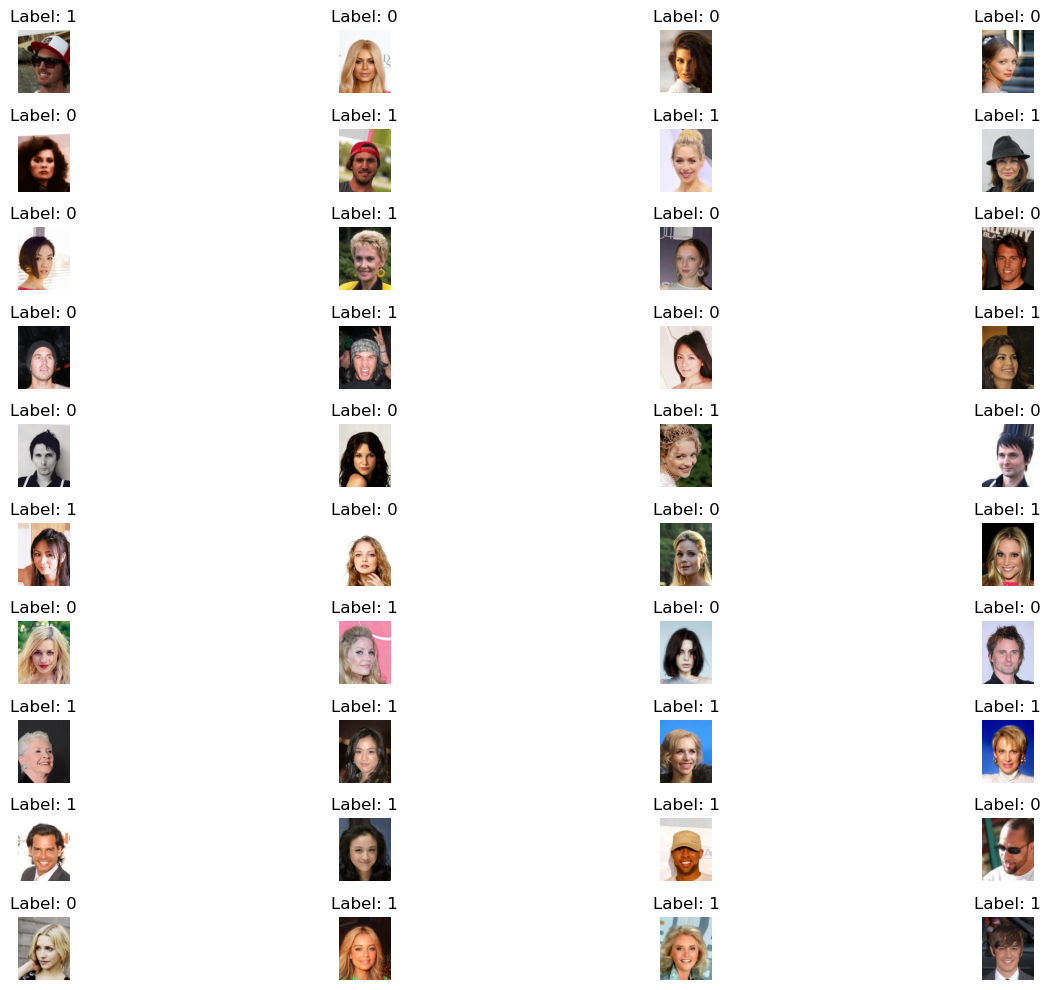

In [30]:
import matplotlib.pyplot as plt

# Parameters
num_images_to_display = 40
images_per_row = 4  # Number of images per row for a grid layout
images_displayed = 0

# Collect and display images
plt.figure(figsize=(15, 10))  # Set the figure size

for X, y in forget_loader:
    # Convert the batch to NumPy
    np_images = X.permute(0, 2, 3, 1).numpy()  # Change shape to (N, H, W, C)
    
    # Loop through images in the batch
    for img, label in zip(np_images, y):
        images_displayed += 1
        
        # Add subplot for each image
        plt.subplot(num_images_to_display // images_per_row, images_per_row, images_displayed)
        plt.imshow(img)  # Assuming the range is already suitable for visualization
        plt.title(f"Label: {label.item()}")  # Display label
        plt.axis("off")
        
        if images_displayed == num_images_to_display:
            break  # Stop after displaying the required number of images
    if images_displayed == num_images_to_display:
        break

plt.tight_layout()  # Adjust spacing between subplots
plt.savefig('2820_new_new.png')
plt.show()


In [10]:
loader, _ = data_manager.get_loader_for('train')

2025-01-26 12:43:01,-1569973494 | INFO | 1836067 - TRAINING WITH 146293 samples


In [13]:

from erasure.utils.config.global_ctx import bcolors


#Create Predictor
current = Local(global_ctx.config.predictor)
current.dataset = data_manager
predictor = global_ctx.factory.get_object(current)
global_ctx.predictor = predictor
global_ctx.logger.info('Global Predictor: ' + str(predictor))

#Create unlearners 
unlearners = []
unlearners_cfg = global_ctx.config.unlearners
for un in unlearners_cfg:
    current = Local(un)
    current.dataset = data_manager
    current.predictor = copy.deepcopy(predictor)
    unlearners.append( global_ctx.factory.get_object(current) )


#Evaluator
current = Local(global_ctx.config.evaluator)
current.unlearners = unlearners
evaluator = global_ctx.factory.get_object(current)

# Evaluations
for unlearner in unlearners:
    global_ctx.logger.info(f'''{bcolors.OKGREEN}####\t\t Evaluating: {unlearner.__class__.__name__} \t\t####{bcolors.ENDC}''')
    evaluator.evaluate(unlearner,predictor)

 

2025-01-25 11:32:03,-1660631110 | INFO | 1212714 - Instantiating: erasure.model.classifiers.resnet18_for_celeba.CelebAResNet18


/NFSHOME/adangelo/miniconda3/envs/representer/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/NFSHOME/adangelo/miniconda3/envs/representer/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


2025-01-25 11:32:04,-1660630687 | INFO | 1212714 - Instantiating: torch.optim.Adam
2025-01-25 11:32:04,-1660630685 | INFO | 1212714 - Instantiating: torch.nn.CrossEntropyLoss
2025-01-25 11:32:04,-1660630682 | INFO | 1212714 - TRAINING WITH 14628 samples


KeyboardInterrupt: 